In [2]:
! pip install pymagnitude pytorch_pretrained_bert tensorboardcolab -q

     |████████████████████████████████| 5.4MB 3.2MB/s 
     |████████████████████████████████| 133kB 15.9MB/s 


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from pymagnitude import Magnitude
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from scipy import spatial
from sklearn.manifold import TSNE
from tensorboardcolab import TensorBoardColab
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm_notebook as tqdm

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

RED, BLUE = '#FF4136', '#0074D9'

In [7]:
sentence = 'the quick brown fox jumps over the lazy dog'
words = sentence.split()
words

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

In [8]:
word2idx = {word: idx for idx, word in enumerate(sorted(set(words)))}
word2idx

{'brown': 0,
 'dog': 1,
 'fox': 2,
 'jumps': 3,
 'lazy': 4,
 'over': 5,
 'quick': 6,
 'the': 7}

In [10]:
idxs = torch.LongTensor([word2idx[word] for word in sentence.split()])
idxs

tensor([7, 6, 0, 2, 3, 5, 7, 4, 1])

In [11]:
embedding_layer = nn.Embedding(num_embeddings=len(word2idx), embedding_dim=3)
embeddings = embedding_layer(idxs)
embeddings, embeddings.shape

(tensor([[ 0.8954,  0.7056, -0.4975],
         [-0.7655,  0.3936,  0.1500],
         [-0.4846, -0.0259, -0.5970],
         [ 0.2894,  1.5901,  0.6806],
         [-1.8506, -0.4434,  2.3044],
         [-0.6100,  0.0162,  0.4726],
         [ 0.8954,  0.7056, -0.4975],
         [-0.5756,  0.6292,  0.1940],
         [ 0.4704, -0.6407,  0.7090]], grad_fn=<EmbeddingBackward>),
 torch.Size([9, 3]))

In [12]:
!wget http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude glove/

--2020-02-16 08:49:29--  http://magnitude.plasticity.ai/glove/light/glove.6B.50d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.92.10
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.92.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102670336 (98M) [binary/octet-stream]
Saving to: ‘glove.6B.50d.magnitude’

glove.6B.50d.magnit 100%[===================>]  97.91M  54.6MB/s    in 1.8s    

2020-02-16 08:49:31 (54.6 MB/s) - ‘glove.6B.50d.magnitude’ saved [102670336/102670336]

--2020-02-16 08:49:31--  http://glove/
Resolving glove (glove)... failed: Name or service not known.
wget: unable to resolve host address ‘glove’
FINISHED --2020-02-16 08:49:31--
Total wall clock time: 2.1s
Downloaded: 1 files, 98M in 1.8s (54.6 MB/s)


In [14]:
!ls -al

total 100280
drwxr-xr-x 1 root root      4096 Feb 16 08:49 .
drwxr-xr-x 1 root root      4096 Feb 16 08:06 ..
drwxr-xr-x 1 root root      4096 Feb 13 17:15 .config
-rw-r--r-- 1 root root 102670336 Oct 27  2018 glove.6B.50d.magnitude
drwxr-xr-x 1 root root      4096 Feb  5 18:37 sample_data


In [16]:
!wc -l glove.6B.50d.magnitude

652242 glove.6B.50d.magnitude


In [0]:
glove_vectors = Magnitude('glove/glove.6B.50d.magnitude')

In [24]:
glove_embeddings = glove_vectors.query(words)
glove_embeddings[0], glove_embeddings.shape

(array([ 8.414140e-02,  5.025940e-02, -8.301820e-02,  2.449760e-02,
         6.950120e-02, -8.949000e-03, -1.000196e-01, -3.595540e-02,
        -1.329000e-04, -1.321705e-01,  5.604660e-02, -2.972530e-02,
        -1.120752e-01,  2.950590e-02, -1.914200e-03,  2.346700e-03,
         2.054020e-02, -2.574970e-02, -1.699536e-01, -2.451980e-02,
        -3.382000e-03, -6.698900e-02, -3.124100e-02, -4.656160e-02,
        -3.861040e-02, -3.788981e-01, -1.544861e-01,  1.993850e-02,
        -8.479560e-02, -3.930490e-02,  8.066102e-01, -3.742880e-02,
        -1.052513e-01, -6.377240e-02,  1.192000e-04,  1.498600e-03,
         3.578630e-02, -3.199990e-02,  2.423800e-03, -1.091480e-02,
        -6.012890e-02, -3.170200e-02, -6.996620e-02, -9.186500e-03,
        -8.907520e-02,  3.781330e-02,  5.606000e-04, -3.706050e-02,
        -2.317710e-02, -1.581798e-01], dtype=float32), (9, 50))

In [0]:
def cosine_similarity(word1, word2):
  vector1, vector2 = glove_vectors.query(word1), glove_vectors.query(word2)
  return 1 - spatial.distance.cosine(vector1.reshape((1,-1)), vector2.reshape((1,-1)))

In [56]:
word_pairs = [
              ('dog', 'cat'),
              ('tree', 'cat'), 
              ('tree', 'leaf'),
              ('king', 'queen'),
]

for word1, word2 in word_pairs:
  print(f'Similarity between "{word1}" and "{word2}" :\t{cosine_similarity(word1, word2):.2f}')

Similarity between "dog" and "cat" :	0.92
Similarity between "tree" and "cat" :	0.57
Similarity between "tree" and "leaf" :	0.74
Similarity between "king" and "queen" :	0.78


In [0]:
ANIMALS = [
    'whale',
    'fish',
    'horse',
    'rabbit',
    'sheep',
    'lion',
    'dog',
    'cat',
    'tiger',
    'hamster',
    'pig',
    'goat',
    'lizard',
    'elephant',
    'giraffe',
    'hippo',
    'zebra',
]

HOUSEHOLD_OBJECTS = [
    'stapler',
    'screw',
    'nail',
    'tv',
    'dresser',
    'keyboard',
    'hairdryer',
    'couch',
    'sofa',
    'lamp',
    'chair',
    'desk',
    'pen',
    'pencil',
    'table',
    'sock',
    'floor',
    'wall',
]

In [59]:
tsne_words_embedded = TSNE(n_components=2).fit_transform(glove_vectors.query(ANIMALS+HOUSEHOLD_OBJECTS))
tsne_words_embedded.shape

(35, 2)

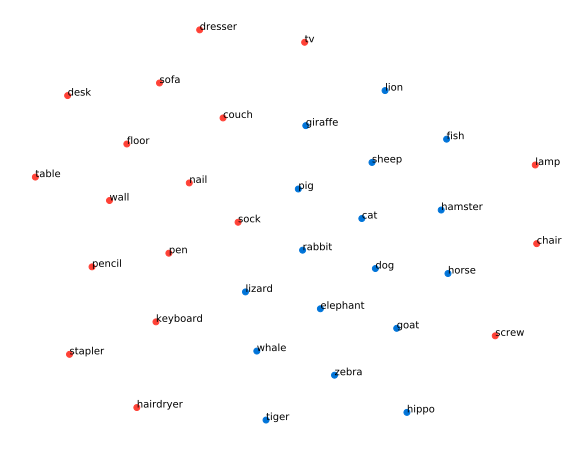

In [63]:
x, y = zip(*tsne_words_embedded)

fig, ax = plt.subplots(figsize=(10, 8))

for i, label in enumerate(ANIMALS + HOUSEHOLD_OBJECTS):
  if label in ANIMALS:
    color = BLUE
  elif label in HOUSEHOLD_OBJECTS:
    color = RED

  ax.scatter(x[i], y[i], c = color)
  ax.annotate(label, (x[i], y[i]))

ax.axis('off')

plt.show()

In [72]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

tbc = TensorBoardColab()

vectors = glove_vectors.query(ANIMALS + HOUSEHOLD_OBJECTS)
with SummaryWriter(log_dir='Graph/') as writer:
  writer.add_embedding(mat=vectors, metadata=ANIMALS+HOUSEHOLD_OBJECTS)

Wait for 8 seconds...
TensorBoard link:
http://22dff5c4.ngrok.io


In [76]:
# %tensorboard --logdir=Graph/
%reload_ext tensorboard
%tensorboard --logdir=Graph/

Reusing TensorBoard on port 6007 (pid 1950), started 0:00:16 ago. (Use '!kill 1950' to kill it.)

In [65]:
!pip install gin-config==0.1.1 

     |████████████████████████████████| 40kB 2.8MB/s 
  Created wheel for gin-config: filename=gin_config-0.1.1-cp36-none-any.whl size=38331 sha256=63c6754e31c059ec8aab8d8e13f69834af1c817677b55fd0b22fedfc360b1e00
  Stored in directory: /root/.cache/pip/wheels/65/92/44/869d6c5d448044e10b0a68edaadec2bb21339c47362c2e8bcb
Successfully built gin-config
  Found existing installation: gin-config 0.3.0
    Uninstalling gin-config-0.3.0:
      Successfully uninstalled gin-config-0.3.0


In [70]:
!pip install tensorboardcolab==0.0.11

  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.11-cp36-none-any.whl size=3397 sha256=46d2c38cbb3050f1de44493bcfb68dde82d7ed6b9fc10d064accf9b433cb8e6c
  Stored in directory: /root/.cache/pip/wheels/08/5c/77/b460d62566770e9dcff502e2d6a4747b664ec482693752e4fe
Successfully built tensorboardcolab
  Found existing installation: tensorboardcolab 0.0.22
    Uninstalling tensorboardcolab-0.0.22:
      Successfully uninstalled tensorboardcolab-0.0.22


[-] Magnitude library  
[-] 